In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from tqdm import tqdm
from pathlib import Path

In [5]:
def load_data(input_file):
    """
    Load waveform data from CSV.
    Expects waveform columns to start with 't'.
    """
    df = pd.read_csv(input_file)
    waveforms = df[[c for c in df.columns if c.startswith("t")]].values
    return df, waveforms

In [6]:
run_id = "run0004"
layer_id = 4
x = 2
y = 0
input_file = f"../data/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
print(input_file)
df, waveforms = load_data(input_file)
print(f"Loaded {len(waveforms)} waveforms with shape {waveforms.shape}")

../data/run0004/layer4_x2_y0.csv
Loaded 12219 waveforms with shape (12219, 400)


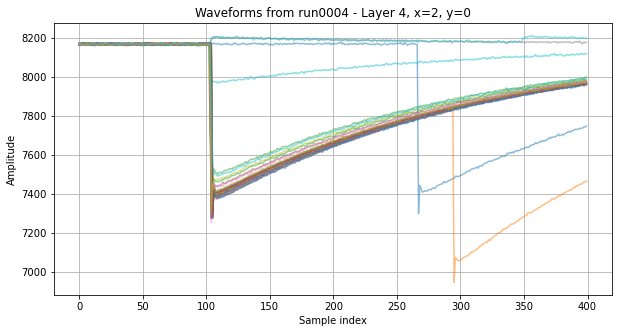

In [9]:
plt.figure(figsize=(10, 5))
for i in range(min(40, len(df))):
    wf = df[[c for c in df.columns if c.startswith("t")]].iloc[i].values
    plt.plot(wf, alpha=0.5)
plt.title(f"Waveforms from {run_id} - Layer {layer_id}, x={x}, y={y}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [10]:
def normalize_waveforms(waveforms):
    min_vals = waveforms.min(axis=1, keepdims=True)
    max_vals = waveforms.max(axis=1, keepdims=True)
    scaled = 2 * (waveforms - min_vals) / (max_vals - min_vals + 1e-8) - 1
    return scaled, min_vals, max_vals

def rescale_waveforms(normalized, min_vals, max_vals):
    return (normalized + 1) / 2 * (max_vals - min_vals) + min_vals

In [68]:
def init_params(input_size, hidden_size):
    W1 = np.random.randn(hidden_size, input_size) * 0.01  # Encoder weights
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(input_size, hidden_size) * 0.01  # Decoder weights
    b2 = np.zeros((input_size, 1))
    return W1, b1, W2, b2

In [69]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def forward(x, W1, b1, W2, b2):
    z1 = W1 @ x + b1          # Encoder linear
    a1 = tanh(z1)          # Encoder activation
    z2 = W2 @ a1 + b2         # Decoder linear
    a2 = tanh(z2)          # Decoder activation (output)
    return z1, a1, z2, a2

def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def backward(x, y_true, z1, a1, z2, a2, W1, W2):
    m = x.shape[1]  # batch size

    dz2 = (a2 - y_true) * tanh_derivative(z2)
    dW2 = dz2 @ a1.T / m
    db2 = np.sum(dz2, axis=1, keepdims=True) / m

    dz1 = (W2.T @ dz2) * tanh_derivative(z1)
    dW1 = dz1 @ x.T / m
    db1 = np.sum(dz1, axis=1, keepdims=True) / m

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

In [70]:
df, waveforms = load_data(input_file)
waveforms = waveforms.astype(np.float32)
waveforms = waveforms[:500]  # optional: limit for faster training
waveforms = waveforms.T      # shape: (time_steps, num_waveforms)
normalized_waveforms, min_vals, max_vals = normalize_waveforms(waveforms)

In [71]:
input_size = normalized_waveforms.shape[0]  # time steps
hidden_size = 64
W1, b1, W2, b2 = init_params(input_size, hidden_size)

In [72]:
learning_rate = 0.01
n_epochs = 1000
losses = []

for epoch in range(n_epochs):
    z1, a1, z2, a2 = forward(normalized_waveforms, W1, b1, W2, b2)
    loss = compute_loss(normalized_waveforms, a2)
    losses.append(loss)

    dW1, db1, dW2, db2 = backward(normalized_waveforms, normalized_waveforms, z1, a1, z2, a2, W1, W2)
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")
        #print(f"Mean Output Sample: {np.mean(a2[:, :5], axis=1)}")

Epoch 0, Loss: 0.852084
Epoch 100, Loss: 0.003751
Epoch 200, Loss: 0.003233
Epoch 300, Loss: 0.003027
Epoch 400, Loss: 0.002812
Epoch 500, Loss: 0.002585
Epoch 600, Loss: 0.002367
Epoch 700, Loss: 0.002163
Epoch 800, Loss: 0.001953
Epoch 900, Loss: 0.001709


In [73]:
def rescale_waveforms(normalized, min_vals, max_vals):
    return (normalized + 1) / 2 * (max_vals - min_vals) + min_vals

denoised_scaled = a2  # output from last forward pass
denoised_waveforms = rescale_waveforms(denoised_scaled, min_vals, max_vals)

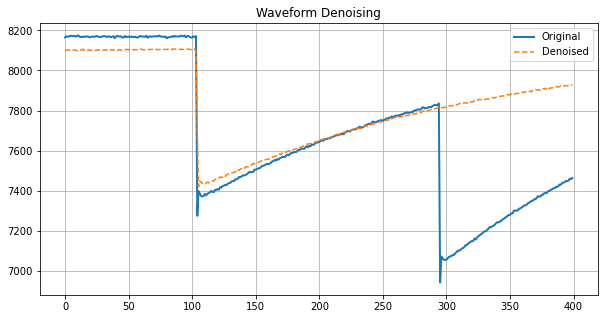

In [74]:
idx = 11
plt.figure(figsize=(10, 5))
plt.plot(waveforms[:, idx], label='Original', linewidth=2)
plt.plot(denoised_waveforms[:, idx], label='Denoised', linestyle='--')
plt.title("Waveform Denoising")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
def plot_denoising_comparison(original, denoised, indices=None, n=5):
    """
    Compare original and denoised waveforms.
    Params:
        original: shape (time_steps, num_waveforms)
        denoised: same shape as original
        indices: list of waveform indices to plot
        n: number of waveforms to show (if indices not specified)
    """
    time_steps = original.shape[0]
    if indices is None:
        indices = np.random.choice(original.shape[1], n, replace=False)
    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(indices):
        #plt.figure(figsize=(10, 4))
        plt.plot(original[:, idx], label='Original (Noisy)', alpha=0.6)
        plt.plot(denoised[:, idx], label='Denoised', linestyle='--', linewidth=2)
        #plt.plot(original[:, idx] - denoised[:, idx], label='Residual (Noise)', linestyle=':', alpha=0.5)
    plt.title(f"Waveform {idx}")
    plt.xlabel("Time step")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

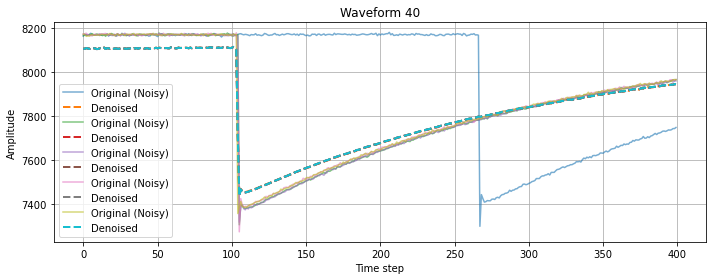

In [76]:
plot_denoising_comparison(waveforms, denoised_waveforms, indices=[0, 10, 20, 30, 40])

In [77]:
# Use same for input and target
input_data = normalized_waveforms
target_data = normalized_waveforms

In [78]:
batch_size = 32
n_samples = input_data.shape[1]
n_batches = n_samples // batch_size
learning_rate = 0.01
n_epochs = 2000
losses = []

for epoch in range(n_epochs):
    epoch_loss = 0

    for i in range(0, n_samples, batch_size):
        # Batch slice
        x_batch = input_data[:, i:i+batch_size]
        y_batch = target_data[:, i:i+batch_size]

        # Forward
        z1, a1, z2, a2 = forward(x_batch, W1, b1, W2, b2)

        # Loss
        batch_loss = compute_loss(y_batch, a2)
        epoch_loss += batch_loss

        # Backward
        dW1, db1, dW2, db2 = backward(x_batch, y_batch, z1, a1, z2, a2, W1, W2)

        # Update
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

    epoch_loss /= n_batches
    losses.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Loss: {epoch_loss:.6f}")


Epoch 0, Avg Loss: 0.001752
Epoch 100, Avg Loss: 0.000639
Epoch 200, Avg Loss: 0.000512
Epoch 300, Avg Loss: 0.000428
Epoch 400, Avg Loss: 0.000356
Epoch 500, Avg Loss: 0.000293
Epoch 600, Avg Loss: 0.000240
Epoch 700, Avg Loss: 0.000196
Epoch 800, Avg Loss: 0.000164
Epoch 900, Avg Loss: 0.000141
Epoch 1000, Avg Loss: 0.000125
Epoch 1100, Avg Loss: 0.000114
Epoch 1200, Avg Loss: 0.000106
Epoch 1300, Avg Loss: 0.000100
Epoch 1400, Avg Loss: 0.000095
Epoch 1500, Avg Loss: 0.000091
Epoch 1600, Avg Loss: 0.000088
Epoch 1700, Avg Loss: 0.000085
Epoch 1800, Avg Loss: 0.000083
Epoch 1900, Avg Loss: 0.000081


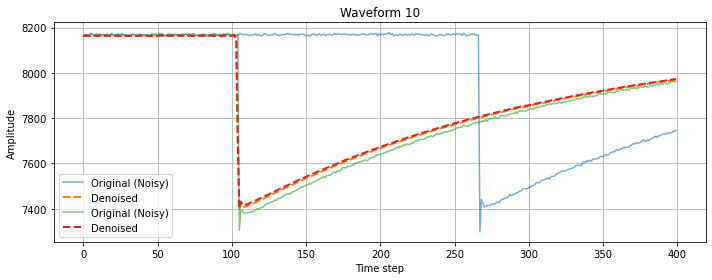

In [79]:
denoised_scaled = a2  # output from last forward pass
denoised_waveforms = rescale_waveforms(denoised_scaled, min_vals, max_vals)
plot_denoising_comparison(waveforms, denoised_waveforms, indices=[0, 10], n=2)


In [80]:
def train_autoencoder(input_data, target_data, hidden_size=32, learning_rate=0.01, n_epochs=2000, batch_size=32):
    input_size = input_data.shape[0]
    n_samples = input_data.shape[1]
    W1, b1, W2, b2 = init_params(input_size, hidden_size)
    losses = []

    for epoch in range(n_epochs):
        # Shuffle data
        perm = np.random.permutation(n_samples)
        input_data = input_data[:, perm]
        target_data = target_data[:, perm]

        epoch_loss = 0
        for i in range(0, n_samples, batch_size):
            x_batch = input_data[:, i:i+batch_size]
            y_batch = target_data[:, i:i+batch_size]

            z1, a1, z2, a2 = forward(x_batch, W1, b1, W2, b2)
            batch_loss = compute_loss(y_batch, a2)
            epoch_loss += batch_loss

            dW1, db1, dW2, db2 = backward(x_batch, y_batch, z1, a1, z2, a2, W1, W2)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        epoch_loss /= (n_samples // batch_size)
        losses.append(epoch_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.6f}")

    return W1, b1, W2, b2, losses

In [94]:
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_denoising_comparison(original, denoised, indices=None, n=5):
    num_waveforms = original.shape[1]
    n = min(n, num_waveforms)
    if indices is None:
        indices = np.random.choice(num_waveforms, n, replace=False)

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        plt.plot(original[:, idx], label=f'Original {idx}', alpha=0.4)
        plt.plot(denoised[:, idx], label=f'Denoised {idx}', linestyle='--')
    plt.title(f"Waveform Comparison (n={n})")
    plt.xlabel("Time step")
    plt.ylabel("Amplitude")
    #plt.xlim(120,200)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [100]:
df, waveforms = load_data(input_file)
# Assume you have waveforms loaded as: waveforms (shape: [n_waveforms, time_steps])
waveforms = waveforms.T  # shape: (time_steps, n_waveforms)

# Normalize
x_scaled, min_vals, max_vals = normalize_waveforms(waveforms)

# Train
W1, b1, W2, b2, losses = train_autoencoder(x_scaled, x_scaled)

# Denoise
_, _, _, denoised_scaled = forward(x_scaled, W1, b1, W2, b2)
denoised = rescale_waveforms(denoised_scaled, min_vals, max_vals)

Epoch 0, Loss: 0.012411
Epoch 100, Loss: 0.000109
Epoch 200, Loss: 0.000078
Epoch 300, Loss: 0.000068
Epoch 400, Loss: 0.000062
Epoch 500, Loss: 0.000056
Epoch 600, Loss: 0.000050
Epoch 700, Loss: 0.000043
Epoch 800, Loss: 0.000037
Epoch 900, Loss: 0.000033
Epoch 1000, Loss: 0.000031
Epoch 1100, Loss: 0.000030
Epoch 1200, Loss: 0.000029
Epoch 1300, Loss: 0.000028
Epoch 1400, Loss: 0.000028
Epoch 1500, Loss: 0.000027
Epoch 1600, Loss: 0.000027
Epoch 1700, Loss: 0.000026
Epoch 1800, Loss: 0.000026
Epoch 1900, Loss: 0.000025


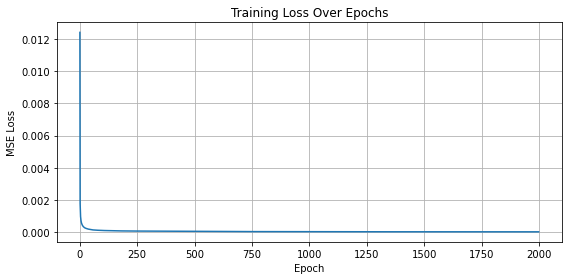

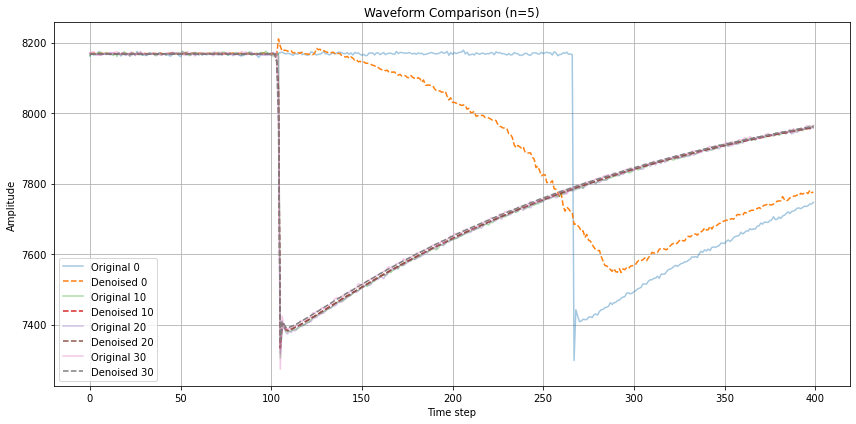

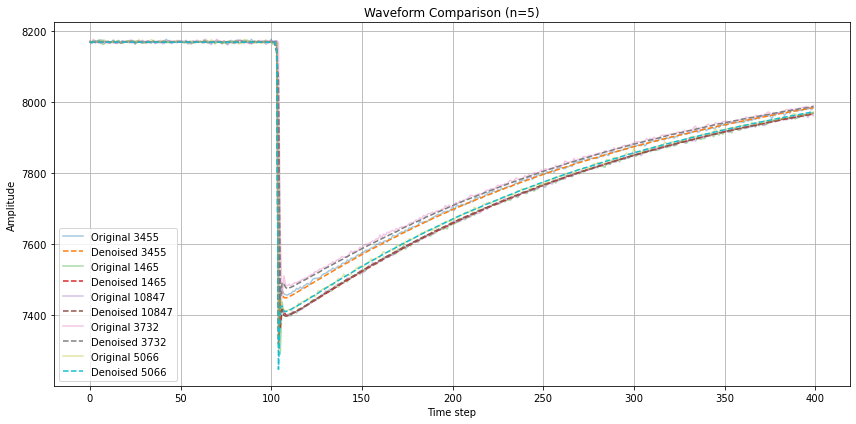

In [101]:

# Plot
plot_loss_curve(losses)
plot_denoising_comparison(waveforms, denoised, indices = [0,10,20,30])
plot_denoising_comparison(waveforms, denoised, n=5)


In [103]:
# Assign to full df
df_denoised = df.copy()
df_denoised[waveform_cols] = denoised.T

output_file = f"../output/{run_id}/layer{layer_id}_x{x}_y{y}_denoised.csv"
df_denoised.to_csv(output_file, index=False)
print(f"Full denoised waveforms saved to {output_file}")

Full denoised waveforms saved to ../output/run0004/layer4_x2_y0_denoised.csv


In [128]:
waveforms = waveforms.T
denoised = denoised.T

In [129]:
import yaml
import sys
from pathlib import Path

# Add 'scripts' folder to Python path
base_dir = Path.cwd().parent  # assumes you're in 'base/notebooks'
scripts_dir = base_dir / 'scripts'
sys.path.append(str(scripts_dir))

# Now you can import your module
import MWD_utils

In [130]:
# load config
mwd_params_path = "../results/best_params_layer4_x2_y0.yaml"
def run_mwd(waveforms, mwd_params_path, quiet=False):
    from MWD_utils import MWD
    with open(mwd_params_path, "r") as f:
        mwd_config = yaml.safe_load(f)
    mwd_params = mwd_config.get("final_parameters", mwd_config)
    mwd_energies = []
    for wf in tqdm(waveforms, desc="MWD energy calculation", disable=quiet):
        _, energy, _ = MWD_utils.MWD(wf, mwd_params)
        mwd_energies.append(energy)
    return np.array(mwd_energies)
    

mwd_energies = run_mwd(waveforms, mwd_params_path, quiet=False)
mwd_denoised = run_mwd(denoised, mwd_params_path, quiet=False)

MWD energy calculation: 100%|████████████████████████████████████████████████████| 12219/12219 [00:24<00:00, 498.67it/s]


In [137]:
from MWD_utils import fit_energy_spectrum, gaussian
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def compare_mwd_energy_spectra(energies_orig, energies_denoised, bins=200, fit=True):
    # Compute shared histogram bins
    all_energies = np.concatenate([energies_orig, energies_denoised])
    hist_range = (all_energies.min(), all_energies.max())
    
    # Compute histograms
    counts_orig, edges = np.histogram(energies_orig, bins=bins, range=hist_range)
    counts_denoised, _ = np.histogram(energies_denoised, bins=bins, range=hist_range)
    centers = (edges[:-1] + edges[1:]) / 2

    plt.figure(figsize=(10, 5))
    plt.plot(centers, counts_orig, label="Original", alpha=0.6)
    plt.plot(centers, counts_denoised, label="Denoised", alpha=0.6)

    if fit:
        # Fit both and overlay Gaussian
        _, _, mu_o, sig_o, res_o = fit_energy_spectrum(energies_orig, bins=bins)
        _, _, mu_d, sig_d, res_d = fit_energy_spectrum(energies_denoised, bins=bins)

        if mu_o and sig_o:
            plt.plot(centers, gaussian(centers, max(counts_orig), mu_o, sig_o),
                     linestyle="--", label=f"Orig Fit: μ={mu_o:.1f}, σ={sig_o:.1f}, R={res_o:.2f}%")

        if mu_d and sig_d:
            plt.plot(centers, gaussian(centers, max(counts_denoised), mu_d, sig_d),
                     linestyle="--", label=f"Denoised Fit: μ={mu_d:.1f}, σ={sig_d:.1f}, R={res_d:.2f}%")

    plt.xlabel("Energy")
    plt.ylabel("Counts")
    plt.xlim(80,130)
    plt.title("MWD Energy Spectra: Original vs Denoised")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

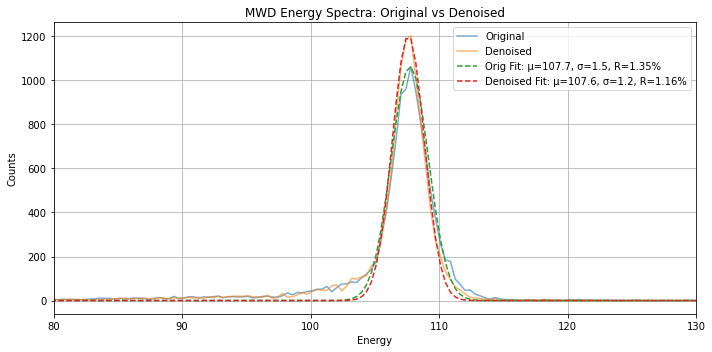

In [138]:
compare_mwd_energy_spectra(mwd_energies, mwd_denoised, bins=2000)

In [133]:
print(waveforms.shape) 

(12219, 400)


In [1]:
run_id = "run0153"
layer_id = 4
x = 2
y = 0
input_file = f"../data/{run_id}/layer{layer_id}_x{x}_y{y}.csv"
print(input_file)
df, waveforms = load_data(input_file)
print(f"Loaded {len(waveforms)} waveforms with shape {waveforms.shape}")

../data/run0153/layer4_x2_y0.csv


NameError: name 'load_data' is not defined